The most basic implementation of Sparse Autoencoder in PyTorch with kTop hard constraint, ReLU on both encoder and decoder, and sum of squares reconstruction loss normalized by input dimension.

In [20]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoder, self).__init__()
        self.training = True
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k_top = k_top
        self.name = "Default Sparse Autoencoder"

        # Encoder maps input to hidden representation
        self.encoder = nn.Linear(input_size, hidden_size)

        # Decoder maps hidden representation back to input space
        self.decoder = nn.Linear(hidden_size, input_size)

    def _topk_mask(self, activations: torch.Tensor) -> torch.Tensor:
        # activations: (batch, hidden)
        k = max(0, min(self.k_top, activations.size(1)))
        _, idx = torch.topk(activations, k, dim=1)
        mask = torch.zeros_like(activations)
        mask.scatter_(1, idx, 1.0)
        return mask

    def forward(self, x):
        pre_activations = self.encoder(x)
        pre_activations = F.relu(pre_activations)
        mask = self._topk_mask(pre_activations)
        h = pre_activations * mask
        x_hat = self.decoder(h)
        return h, x_hat


    def compute_loss(self, x, h, x_hat):
        # We compute sum of squares and normalize by input dimension 'd'
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        return recon_loss

class SparseAutoencoderInit(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoderInit, self).__init__(input_size, hidden_size, k_top)

        self.name = "Sparse Autoencoder with just weight initialization"
        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder[0].weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder[0].weight.t())

class SparseAutoencoderJumpReLU(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20, jump_value=0.1):
        super(SparseAutoencoderJumpReLU, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Jump ReLU"
        self.jump_value = jump_value

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        # Apply JumpReLU
        h = torch.where(h > self.jump_value, h, torch.zeros_like(h))
        x_hat = self.decoder(h)
        return h, x_hat

class SparseAutoencoderInitJumpReLU(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20, jump_value=0.1):
        super(SparseAutoencoderInitJumpReLU, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Initialization and Jump ReLU"
        self.jump_value = jump_value

        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder[0].weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder[0].weight.t())


    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        # Apply JumpReLU
        h = torch.where(h > self.jump_value, h, torch.zeros_like(h))
        x_hat = self.decoder(h)
        return h, x_hat

Implementing auxiliary loss SAE

In [21]:

class SparseAutoencoderAuxLoss(SparseAutoencoder):
    def __init__(self, input_size, hidden_size, k_top, k_aux, k_aux_param, dead_feature_threshold):
        super(SparseAutoencoderAuxLoss, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Auxiliary Loss"
        # k_aux is typically 2*k or more to revive dead features
        self.k_aux = k_aux if k_aux is not None else 2 * k_top
        self.k_aux_param = k_aux_param
        # Track dead features: count steps since each feature was last active
        self.register_buffer('steps_since_active', torch.zeros(hidden_size))
        self.dead_feature_threshold = dead_feature_threshold

    # Function to track which features are dead
    def _update_dead_features(self, h: torch.Tensor):
        # Feature is active if ANY sample in batch activates it
        active_mask = (h.abs() > 1e-8).any(dim=0)

        # Increment counter for inactive features, reset for active ones
        self.steps_since_active += 1
        self.steps_since_active[active_mask] = 0

    def _get_dead_feature_mask(self) -> torch.Tensor:
        """Return boolean mask of dead features"""
        return self.steps_since_active > self.dead_feature_threshold

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        x_hat = self.decoder(h)

        # Track dead features during training
        if self.training:
            self._update_dead_features(h)

        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        # Main reconstruction loss
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        # Auxiliary loss using dead features only
        aux_loss = torch.tensor(0.0, device=x.device)

        if self.training:
            dead_mask = self._get_dead_feature_mask()  # (hidden_size,)
            n_dead = dead_mask.sum().item()

            if n_dead > 0:
                # Compute reconstruction error: e = x - x_hat
                recon_error_vec = x - x_hat  # (batch, input_size)

                # Get raw activations again (before TopK masking)
                with torch.no_grad():
                    h_raw = self.encoder(x)

                # Select only dead features
                h_dead = h_raw * dead_mask.float().unsqueeze(0)  # (batch, hidden_size)

                # Select top-k_aux dead features
                k_aux_features = min(self.k_aux, n_dead)
                _, idx_aux = torch.topk(h_dead, k_aux_features, dim=1)
                mask_aux = torch.zeros_like(h_dead)
                mask_aux.scatter_(1, idx_aux, 1.0)

                # Sparse activations using only dead features
                z_aux = h_raw * mask_aux  # (batch, hidden_size)

                # Reconstruct error using dead features
                e_hat = self.decoder(z_aux)  # (batch, input_size)

                # Auxiliary loss: ||e - e_hat||^2
                aux_loss = torch.sum((recon_error_vec - e_hat) ** 2) / self.input_size

        # Total loss
        total_loss = recon_loss + self.k_aux_param * aux_loss

        return total_loss, recon_loss, aux_loss

Complete with relu, init and aux loss implementation.

In [22]:

class SparseAutoencoderComplete(SparseAutoencoder):
    def __init__(self, input_size, hidden_size, k_top, k_aux, k_aux_param, dead_feature_threshold, jump_value):
        super(SparseAutoencoderComplete, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with weight init., JumpReLU and Auxiliary Loss"
        self.jump_value = jump_value

        # k_aux is typically 2*k or more to revive dead features
        self.k_aux = k_aux if k_aux is not None else 2 * k_top
        self.k_aux_param = k_aux_param
        # Track dead features: count steps since each feature was last active
        self.register_buffer('steps_since_active', torch.zeros(hidden_size))
        self.dead_feature_threshold = dead_feature_threshold

        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder[0].weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder[0].weight.t())

    # Function to track which features are dead
    def _update_dead_features(self, h: torch.Tensor):
        # Feature is active if ANY sample in batch activates it
        active_mask = (h.abs() > 1e-8).any(dim=0)

        # Increment counter for inactive features, reset for active ones
        self.steps_since_active += 1
        self.steps_since_active[active_mask] = 0

    def _get_dead_feature_mask(self) -> torch.Tensor:
        """Return boolean mask of dead features"""
        return self.steps_since_active > self.dead_feature_threshold

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        # Apply JumpReLU
        h = torch.where(h > self.jump_value, h, torch.zeros_like(h))
        x_hat = self.decoder(h)

        # Track dead features during training
        if self.training:
            self._update_dead_features(h)

        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        # Main reconstruction loss
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / self.input_size

        # Auxiliary loss using dead features only
        aux_loss = torch.tensor(0.0, device=x.device)

        if self.training:
            dead_mask = self._get_dead_feature_mask()  # (hidden_size,)
            n_dead = dead_mask.sum().item()

            if n_dead > 0:
                # Compute reconstruction error: e = x - x_hat
                recon_error_vec = x - x_hat  # (batch, input_size)

                # Get raw activations again (before TopK masking)
                with torch.no_grad():
                    h_raw = self.encoder(x)

                # Select only dead features
                h_dead = h_raw * dead_mask.float().unsqueeze(0)  # (batch, hidden_size)

                # Select top-k_aux dead features
                k_aux_features = min(self.k_aux, n_dead)
                _, idx_aux = torch.topk(h_dead, k_aux_features, dim=1)
                mask_aux = torch.zeros_like(h_dead)
                mask_aux.scatter_(1, idx_aux, 1.0)

                # Sparse activations using only dead features
                z_aux = h_raw * mask_aux  # (batch, hidden_size)

                # Reconstruct error using dead features
                e_hat = self.decoder(z_aux)  # (batch, input_size)

                # Auxiliary loss: ||e - e_hat||^2
                aux_loss = torch.sum((recon_error_vec - e_hat) ** 2) / self.input_size

        # Total loss
        total_loss = recon_loss + self.k_aux_param * aux_loss

        return total_loss, recon_loss, aux_loss


First lets try simple training on MNIST to see if the model can learn to reconstruct the input.

In [23]:
from torch import optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms


def load_mnist_data(batch_size=256):
    # First load raw data to compute mean
    raw_transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to [0,1] and creates tensor
    ])

    # Load training set to compute mean
    trainset_raw = torchvision.datasets.MNIST(root='./data', train=True,
                                              download=True, transform=raw_transform)

    # Compute mean over entire training set
    train_loader_temp = DataLoader(trainset_raw, batch_size=len(trainset_raw), shuffle=False)
    all_data = next(iter(train_loader_temp))[0]
    all_data = all_data.view(all_data.size(0), -1)  # Flatten to (N, 784)
    dataset_mean = all_data.mean(dim=0)  # Mean across samples, shape (784,)

    # Define preprocessing transform with mean subtraction and normalization
    def preprocess(x):
        x_flat = x.view(-1)  # Flatten from (1, 28, 28) to (784,)
        x_centered = x_flat - dataset_mean  # Subtract mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)  # Normalize to unit norm
        return x_norm

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(preprocess)
    ])

    # Load datasets with proper preprocessing
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, dataset_mean

def train_sparse_autoencoder(train_loader, num_epochs=50, learning_rate=0.001, input_size=784, hidden_size=64, k_top=20, JumpReLU=0.1, k_aux=None, k_aux_param=1/32, dead_feature_threshold=1000, modelType = "SAE"):
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if modelType == "SAE":
        model = SparseAutoencoder(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "SAE_Init_JumpReLU":
        model = SparseAutoencoderInitJumpReLU(input_size=input_size, hidden_size=hidden_size, k_top=k_top, jump_value=JumpReLU).to(device)
    elif modelType == "SAE_JumpReLU":
        model = SparseAutoencoderJumpReLU(input_size=input_size, hidden_size=hidden_size, k_top=k_top, jump_value=JumpReLU).to(device)
    elif modelType == "SAE_Init":
        model = SparseAutoencoderInit(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "SAE_AuxLoss":
        model = SparseAutoencoderAuxLoss(input_size=input_size, hidden_size=hidden_size, k_top=k_top, k_aux=k_aux,
                                         k_aux_param=k_aux_param, dead_feature_threshold=dead_feature_threshold).to(device)
    elif modelType == "Complete":
        model = SparseAutoencoderComplete(input_size=input_size, hidden_size=hidden_size, k_top=k_top, k_aux=k_aux,
                                         k_aux_param=k_aux_param, dead_feature_threshold=dead_feature_threshold, jump_value=JumpReLU).to(device)
    else:
        raise ValueError("Invalid modelType specified.")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.view(-1, 28*28).to(device)
            optimizer.zero_grad()
            h, outputs = model(inputs)
            if modelType == "SAE_AuxLoss" or modelType == "Complete":
                loss, mse_loss, aux_loss = model.compute_loss(inputs, h, outputs)
            else:
                loss = model.compute_loss(inputs, h, outputs)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                model.decoder.weight.clamp_(0.0)
                if model.decoder.bias is not None:
                    model.decoder.bias.clamp_(0.0)
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    print('Finished Training')
    return model



Visualization functions for weights

In [24]:
import matplotlib.pyplot as plt

# Visualization of learned features
def visualize_weights_decoder(model, num_features=64):
    weights = model.decoder.weight.data.cpu().numpy().T
    x_images = int(math.ceil(math.sqrt(num_features)))
    y_images = int(math.ceil(num_features / x_images))
    plt.figure(figsize=(x_images, y_images))
    plt.title(f'{model.name} Decoder Weights Visualization')
    for i in range(num_features):
        plt.subplot(x_images, y_images, i + 1)
        plt.imshow(weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Visualization of learned features
def visualize_weights_encoder(model, num_features=64):
    # find most appropriate square root
    x_images = int(math.ceil(math.sqrt(num_features)))
    y_images = int(math.ceil(num_features / x_images))
    weights = model.encoder[0].weight.data.cpu().numpy()
    plt.figure(figsize=(x_images, y_images))
    plt.title(f'{model.name} Encoder Weights Visualization')
    for i in range(num_features):
        plt.subplot(x_images, y_images, i + 1)
        plt.imshow(weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

Function to count dead neurons on the dataset given

In [25]:
#
def count_dead_neurons(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    dead_neurons = torch.ones(model.hidden_size, dtype=torch.bool).to(device)

    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            inputs = inputs.view(-1, 28*28).to(device)
            h, _ = model(inputs)
            dead_neurons &= (h.sum(dim=0) == 0)

    num_dead = dead_neurons.sum().item()
    print(f'Number of dead neurons in {model.name}: {num_dead} out of {model.hidden_size}')
    return num_dead

def test_loss(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            inputs, _ = data
            inputs = inputs.view(-1, 28*28).to(device)
            h, outputs = model(inputs)
            loss_output = model.compute_loss(inputs, h, outputs)
            if isinstance(loss_output, tuple):
                loss, *_ = loss_output
            else:
                loss = loss_output
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss


Initializing

In [26]:
train_loader, test_loader = load_mnist_data(batch_size=256)

ValueError: too many values to unpack (expected 2)

# Test 1: Number of epochs on dead neurons and MSE, lr = 0.001, hidden size = 64, k = 20

Prediction: Initially the number of dead neurons will go down, but when the model will quickly specialize with the same amount of dead neurons after some epochs.

In [9]:
# number_of_epochs = range(5, 105, 5)
# dead_neurons_results = []
# mse_results = []
# for epochs in number_of_epochs:
#     print(f'Training for {epochs} epochs')
#     model = train_sparse_autoencoder(train_loader, num_epochs=epochs, learning_rate=0.001, input_size=784, hidden_size=64, k_param=10)
#     dead_neurons = count_dead_neurons(model, train_loader)
#     mse = test_loss(model, test_loader)
#     dead_neurons_results.append(dead_neurons)
#     mse_results.append(mse)

# this one with
# number_of_epochs = range(5, 105, 5)
# dead_neurons_results = []
# mse_results = []
# for epochs in number_of_epochs:
#     print(f'Training for {epochs} epochs')
#     model = train_sparse_autoencoder(train_loader, num_epochs=epochs, learning_rate=0.001, k_top=10, k_aux_param=1/128, k_aux=20, dead_feature_threshold=256, modelType = "SAE_AuxLoss")
#     dead_neurons = count_dead_neurons(model, train_loader)
#     mse = test_loss(model, test_loader)
#     dead_neurons_results.append(dead_neurons)
#     mse_results.append(mse)

Results visualization

In [10]:
# import numpy as np
# from matplotlib import pyplot as plt
# # Visualize dead neurons over epochs
# # Visualize MSE over epochs
# x = np.array(number_of_epochs)
# y_dead = np.array(dead_neurons_results)
# y_mse = np.array(mse_results)
#
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#
# # Dead neurons plot
# axes[0].plot(x, y_dead, marker='o', linestyle='-', color='C1')
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Dead neurons')
# axes[0].set_title('Dead neurons vs epochs')
# axes[0].grid(alpha=0.3)
# axes[0].set_xticks(x)
#
# # MSE plot
# axes[1].plot(x, y_mse, marker='o', linestyle='-', color='C0')
# axes[1].set_xlabel('Epochs')
# axes[1].set_ylabel('MSE')
# axes[1].set_title('MSE vs epochs')
# axes[1].grid(alpha=0.3)
# axes[1].set_xticks(x)
#
# plt.tight_layout()
#
# plt.show()

# Test 2: Dead neuron reduction with initialization and JumpReLU

In [11]:
# modelSAE = train_sparse_autoencoder(train_loader, num_epochs=30, learning_rate=0.001, input_size=784, hidden_size=64, k_param=10, modelType = "SAE")
# modelInitJumpReLU = train_sparse_autoencoder(train_loader, num_epochs=30, learning_rate=0.001, input_size=784, hidden_size=64, k_param=10, JumpReLU=0.1, modelType = "SAE_Init_JumpReLU")

In [12]:
# visualize_weights_decoder(modelSAE, 64)
# visualize_weights_decoder(modelInitJumpReLU, 64)
# count_dead_neurons(modelSAE, train_loader)
# count_dead_neurons(modelInitJumpReLU, train_loader)
# test_loss(modelSAE, test_loader)
# test_loss(modelInitJumpReLU, test_loader)

Woah, the initialization with JumpReLU reduced dead neurons to just one and REDUCED THE MSE as well!

Now I want to check the difference with these components separated and maybe later also adding auxiliary loss "dead grad problem".

In [13]:
# modelInit = train_sparse_autoencoder(train_loader, num_epochs=30, learning_rate=0.001, input_size=784, hidden_size=64, k_param=10, modelType = "SAE_Init")
# modelJumpReLU = train_sparse_autoencoder(train_loader, num_epochs=30, learning_rate=0.001, input_size=784, hidden_size=64, k_param=10, JumpReLU=0.1, modelType = "SAE_JumpReLU")
modelBase = train_sparse_autoencoder(train_loader, num_epochs=15, learning_rate=0.001, input_size=784, hidden_size=64, k_top=10, modelType = "SAE")
#

Epoch [1/15], Loss: 13.0194
Epoch [2/15], Loss: 8.8530
Epoch [3/15], Loss: 8.2779
Epoch [4/15], Loss: 8.0006
Epoch [5/15], Loss: 7.7912
Epoch [6/15], Loss: 7.6927
Epoch [7/15], Loss: 7.5429
Epoch [8/15], Loss: 7.3964
Epoch [9/15], Loss: 7.3191
Epoch [10/15], Loss: 7.2174
Epoch [11/15], Loss: 7.1458
Epoch [12/15], Loss: 7.0802
Epoch [13/15], Loss: 7.0216
Epoch [14/15], Loss: 6.9367
Epoch [15/15], Loss: 6.8006
Finished Training


In [14]:

#modelAuxLoss = train_sparse_autoencoder(train_loader, num_epochs=50, learning_rate=0.001, k_top=5, k_aux_param=1/64, k_aux=10, dead_feature_threshold=3000, modelType = "SAE_AuxLoss")

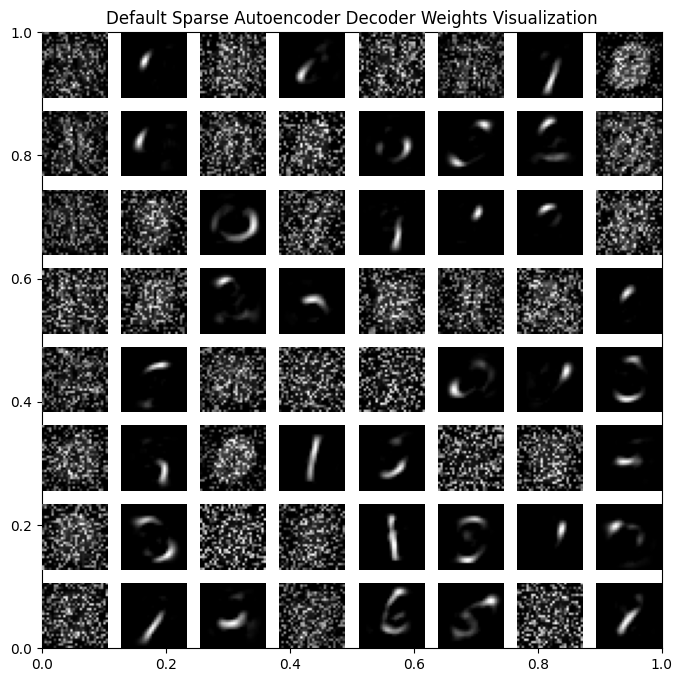

Number of dead neurons in Default Sparse Autoencoder: 15 out of 64
Test Loss: 6.5302


6.5301806382834915

In [27]:
# visualize_weights_decoder(modelAuxLoss, 64)
# count_dead_neurons(modelAuxLoss, train_loader)
# test_loss(modelAuxLoss, test_loader)
visualize_weights_decoder(modelBase, 64)
count_dead_neurons(modelBase, train_loader)
test_loss(modelBase, test_loader)

Test with a bunch of features

In [133]:
big_space_model = train_sparse_autoencoder(train_loader, num_epochs=30, learning_rate=0.001, input_size=784, hidden_size=784, k_top=10, JumpReLU=0.1, dead_feature_threshold=256, modelType = "Complete")

Epoch [1/30], Loss: 8.3805
Epoch [2/30], Loss: 6.1290
Epoch [3/30], Loss: 5.8663
Epoch [4/30], Loss: 5.6504
Epoch [5/30], Loss: 5.3953
Epoch [6/30], Loss: 5.1757
Epoch [7/30], Loss: 5.0413
Epoch [8/30], Loss: 4.8960
Epoch [9/30], Loss: 4.8349
Epoch [10/30], Loss: 4.7109
Epoch [11/30], Loss: 4.6260
Epoch [12/30], Loss: 4.5655
Epoch [13/30], Loss: 4.5099
Epoch [14/30], Loss: 4.4682
Epoch [15/30], Loss: 4.4372
Epoch [16/30], Loss: 4.4287
Epoch [17/30], Loss: 4.4323
Epoch [18/30], Loss: 4.4473
Epoch [19/30], Loss: 4.4854
Epoch [20/30], Loss: 4.5030
Epoch [21/30], Loss: 4.5151
Epoch [22/30], Loss: 4.5343
Epoch [23/30], Loss: 4.5493
Epoch [24/30], Loss: 4.5699
Epoch [25/30], Loss: 4.5795
Epoch [26/30], Loss: 4.5918
Epoch [27/30], Loss: 4.6038
Epoch [28/30], Loss: 4.6078
Epoch [29/30], Loss: 4.6010
Epoch [30/30], Loss: 4.5997
Finished Training


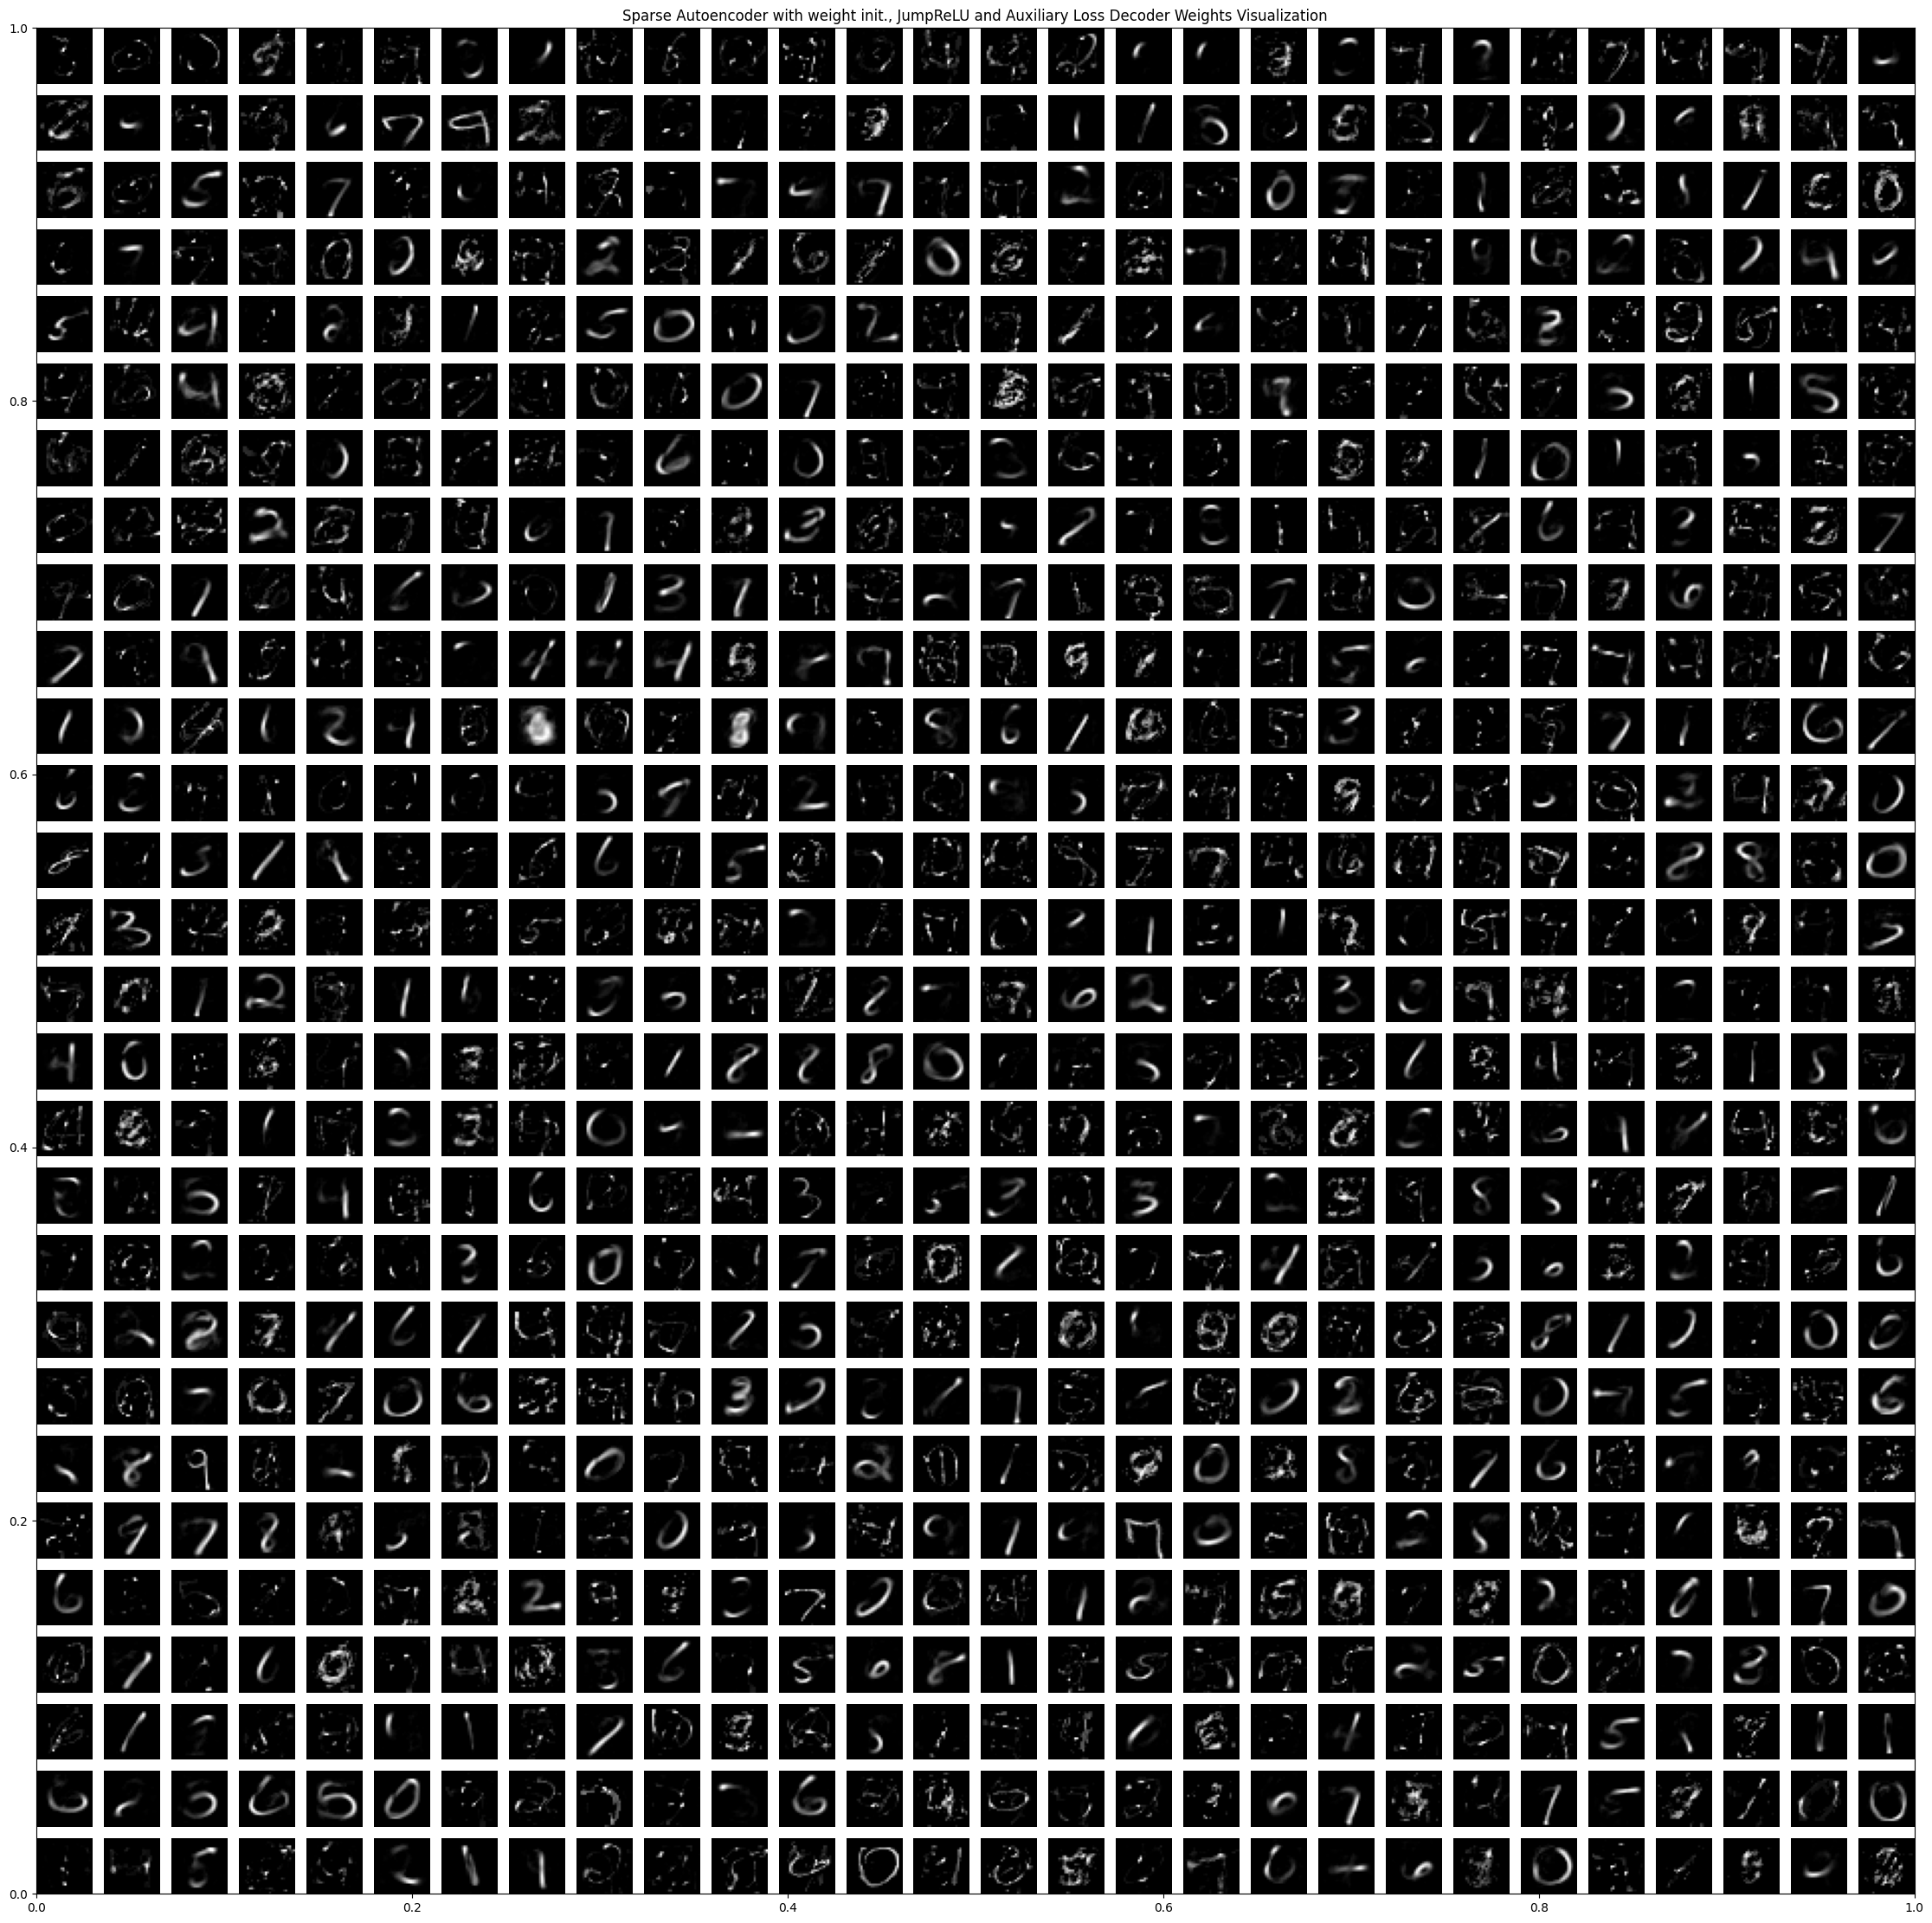

Number of dead neurons in Sparse Autoencoder with weight init., JumpReLU and Auxiliary Loss: 457 out of 784
Test Loss: 4.7002


4.700218337029218

In [134]:
visualize_weights_decoder(big_space_model, 784)
count_dead_neurons(big_space_model, train_loader)
test_loss(big_space_model, test_loader)

# Test with most complete model for best test loss parts based representation with different hyperparams

todo other models too

In [148]:
number_of_epochs = [15, 30, 50]
k_top = [5, 10, 15, 30]

dead_neurons_results = []
mse_results = []
for k_top in k_top:
    for epochs in number_of_epochs:
        print(f'Training for {epochs} epochs')
        model = train_sparse_autoencoder(train_loader, num_epochs=epochs, learning_rate=0.001, input_size=784, hidden_size=64, k_top=k_top, modelType="SAE_Init_JumpReLU")
        dead_neurons = count_dead_neurons(model, train_loader)
        mse = test_loss(model, test_loader)
        dead_neurons_results.append(f'for k_top {k_top}, epochs {epochs} dead_neurons - {dead_neurons}')
        mse_results.append(f'for k_top {k_top}, epochs {epochs} mse - {mse}')



Training for 15 epochs
Epoch [1/15], Loss: 11.5719
Epoch [2/15], Loss: 8.2869
Epoch [3/15], Loss: 7.7829
Epoch [4/15], Loss: 7.5670
Epoch [5/15], Loss: 7.4091
Epoch [6/15], Loss: 7.2984
Epoch [7/15], Loss: 7.2130
Epoch [8/15], Loss: 7.1563
Epoch [9/15], Loss: 7.1215
Epoch [10/15], Loss: 7.0937
Epoch [11/15], Loss: 7.0714
Epoch [12/15], Loss: 7.0498
Epoch [13/15], Loss: 7.0336
Epoch [14/15], Loss: 7.0195
Epoch [15/15], Loss: 7.0071
Finished Training
Number of dead neurons in Sparse Autoencoder with Initialization and Jump ReLU: 10 out of 64
Test Loss: 6.8275
Training for 30 epochs
Epoch [1/30], Loss: 11.3816
Epoch [2/30], Loss: 8.3228
Epoch [3/30], Loss: 7.7481
Epoch [4/30], Loss: 7.5464
Epoch [5/30], Loss: 7.4342
Epoch [6/30], Loss: 7.3584
Epoch [7/30], Loss: 7.2839
Epoch [8/30], Loss: 7.2159
Epoch [9/30], Loss: 7.1545
Epoch [10/30], Loss: 7.0965
Epoch [11/30], Loss: 7.0661
Epoch [12/30], Loss: 7.0296
Epoch [13/30], Loss: 7.0045
Epoch [14/30], Loss: 6.9860
Epoch [15/30], Loss: 6.9693
E

In [149]:
print(dead_neurons_results)
print(mse_results)

['for k_top 5, epochs 15 dead_neurons - 10', 'for k_top 5, epochs 30 dead_neurons - 9', 'for k_top 5, epochs 50 dead_neurons - 7', 'for k_top 10, epochs 15 dead_neurons - 3', 'for k_top 10, epochs 30 dead_neurons - 1', 'for k_top 10, epochs 50 dead_neurons - 4', 'for k_top 15, epochs 15 dead_neurons - 0', 'for k_top 15, epochs 30 dead_neurons - 0', 'for k_top 15, epochs 50 dead_neurons - 1', 'for k_top 30, epochs 15 dead_neurons - 3', 'for k_top 30, epochs 30 dead_neurons - 3', 'for k_top 30, epochs 50 dead_neurons - 0']
['for k_top 5, epochs 15 mse - 6.827500219643116', 'for k_top 5, epochs 30 mse - 6.749846535176038', 'for k_top 5, epochs 50 mse - 6.739099259674549', 'for k_top 10, epochs 15 mse - 5.331928429752589', 'for k_top 10, epochs 30 mse - 5.209707026928664', 'for k_top 10, epochs 50 mse - 5.298283399641514', 'for k_top 15, epochs 15 mse - 4.522689714282751', 'for k_top 15, epochs 30 mse - 4.460387111455202', 'for k_top 15, epochs 50 mse - 4.465180952101946', 'for k_top 30, e